In [1]:
library(tidyverse)
library(clusterProfiler)
library(BiocParallel)
library(parallel)
library(org.Hs.eg.db)
library(AnnotationDbi)
library(stats4)
library(BiocGenerics)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE
clusterProfiler v3.14.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:purrr’:

    simplify

Loading required package: AnnotationDbi
Loading r

In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")

In [3]:
dset_idx <- 1

In [4]:
network_mm_gs_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_gene_mm_gs.tsv"))
network_me_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_eigengene_traits.tsv"))
gene2id_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/hugo2entrez.tsv"))

Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character(),
  module = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  module = col_character(),
  figo_stage_1_cor = col_double(),
  figo_stage_2_cor = col_double(),
  figo_stage_3_cor = col_double(),
  figo_stage_4_cor = col_double(),
  figo_stage_1_pval = col_double(),
  figo_stage_2_pval = col_double(),
  figo_stage_3_pval = col_double(),
  figo_stage_4_pval = col_double(),
  figo_stage_1_qval = col_double(),
  figo_stage_2_qval = col_double(),
  figo_stage_3_qval = col_double(),
  figo_stage_4_qval = col_double(),
  vital_hr = col_double(),
  vital_dev_cor = col_double(),
  vital_pval = col_double(),
  vital_qval = col_double()
)
Parsed with column specification:
cols(
  hugo_symbol = col_character(),
  entrez_gene_id = col_double()
)


In [5]:
make_ea_df <- function(res, ea_type) {
    if (ea_type == "GO") {
        df <- tibble(
            type = res$Description,
            geneIDs = res$geneID,
            count = res$Count,
            ratio = sapply(res$GeneRatio, FUN = function(x) { eval(parse(text = x)) }),
            qval = res$qvalue,
            ont = as.character(res$ONTOLOGY)
        )
    } else if (ea_type == "KEGG") {
        df <- tibble(
            type = res$Description,
            geneIDs = res$geneID,
            count = res$Count,
            ratio = sapply(res$GeneRatio, FUN = function(x) { eval(parse(text = x)) }),
            qval = res$qvalue
        )
    }
    return(df)
}


ea_plot <- function(df) {
    ggplot(df) +
        geom_bar(aes(x = reorder(type, (-log10(qval))), y = -log10(qval)), stat = "identity") +
        theme_classic() +
        theme(
            axis.title.y = element_blank()
        ) +
        labs(y = expression("-log"[10]*"(q-value)")) +
        coord_flip()
}

# Collapse network FIGO significance 
We only care if a module is significant for $\geq 1$ FIGO stages

In [6]:
condensed_me_df <- network_me_df %>%
    condense_figo(include_pvals = TRUE) %>%
    dplyr::rename_if(!startsWith(colnames(.), "module"), ~ gsub("^", "me_", .))

In [7]:
joined_df <- network_mm_gs_df %>%
    dplyr::select(geneID, module, mm_pval, mm_cor) %>%
    inner_join(condensed_me_df, by = "module") %>%
    inner_join(gene2id_df, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::select(geneID, entrez_gene_id, everything())

In [8]:
figo_sig_df <- joined_df %>%
    dplyr::filter(me_figo_min_qval < 0.05 & mm_pval < 0.01)
# Try being less strict with survival?
survival_sig_df <- joined_df %>%
    dplyr::filter(me_vital_qval < 0.1 & mm_pval < 0.01)

# GSEA

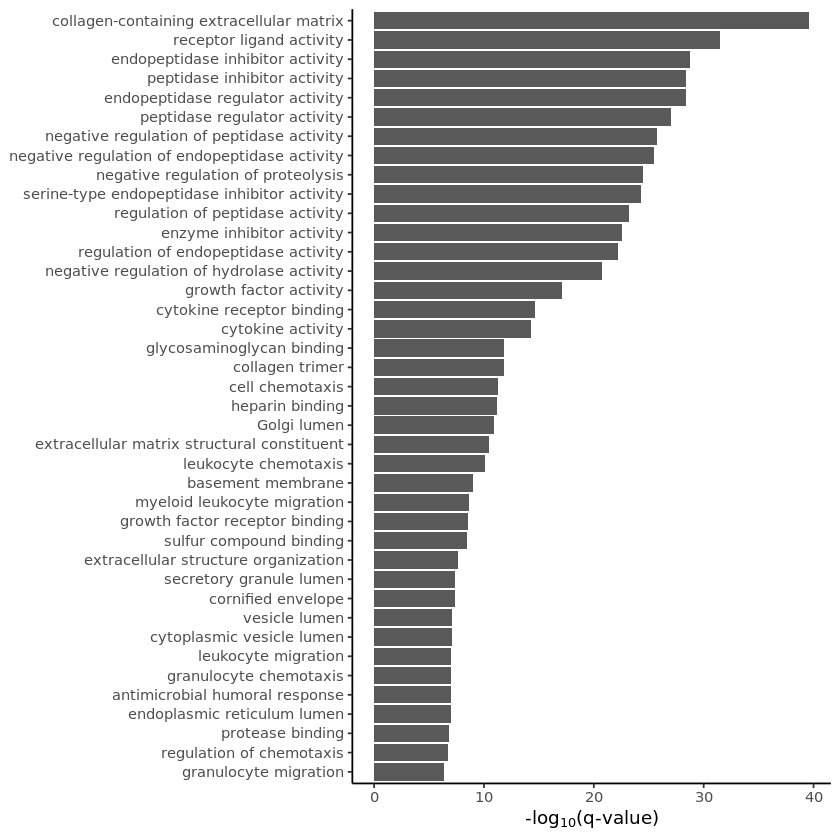

In [9]:
if (nrow(figo_sig_df > 0)) {
    figo_go_res <- enrichGO(figo_sig_df$entrez_gene_id, "org.Hs.eg.db", ont = "ALL", readable = TRUE)
    figo_go_df <- make_ea_df(figo_go_res, ea_type = "GO")
    ea_plot(figo_go_df %>% dplyr::top_n(n = -40, wt = qval))
}

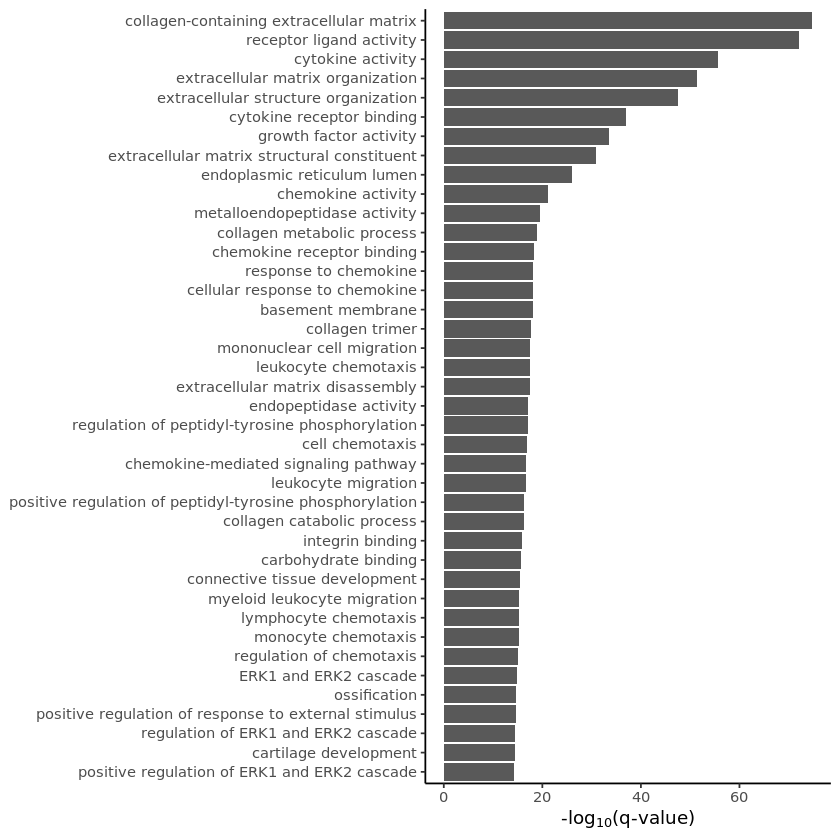

In [10]:
if (nrow(survival_sig_df) > 0) {
    survival_go_res <- enrichGO(survival_sig_df$entrez_gene_id, "org.Hs.eg.db", ont = "ALL", readable = TRUE)
    survival_go_df <- make_ea_df(survival_go_res, ea_type = "GO")
    ea_plot(survival_go_df %>% dplyr::top_n(n = -40, wt = qval))
}

# Pathway EA

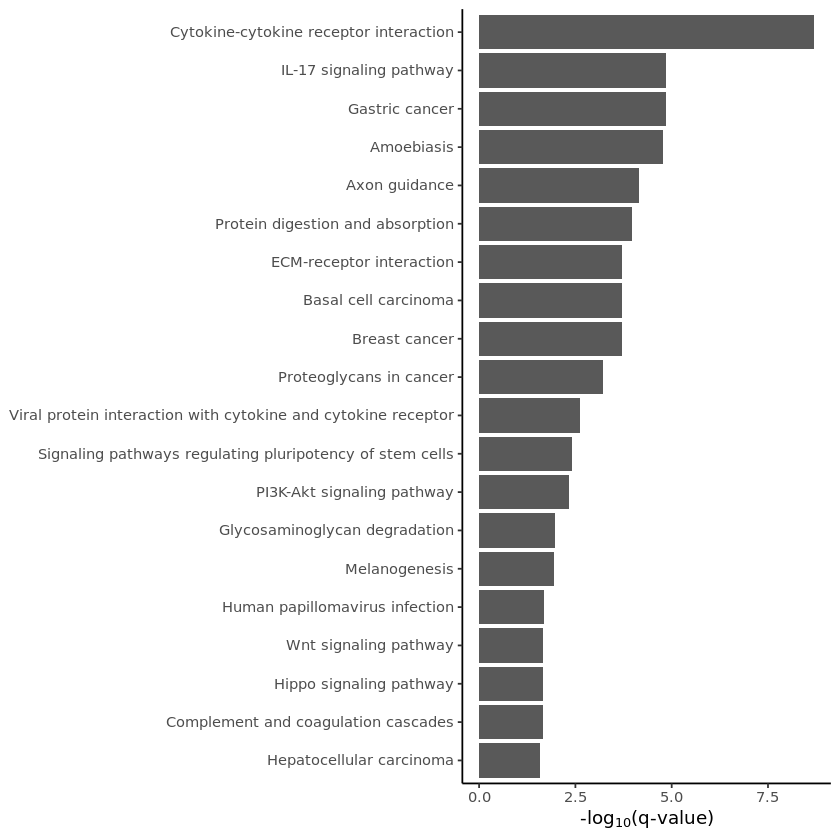

In [11]:
if (nrow(figo_sig_df) > 0) {
    figo_kegg_res <- enrichKEGG(gene = figo_sig_df$entrez_gene_id, organism = "hsa")
    figo_kegg_df <- make_ea_df(figo_kegg_res, ea_type = "KEGG")
    ea_plot(figo_kegg_df %>% dplyr::top_n(n = -40, wt = qval))
}

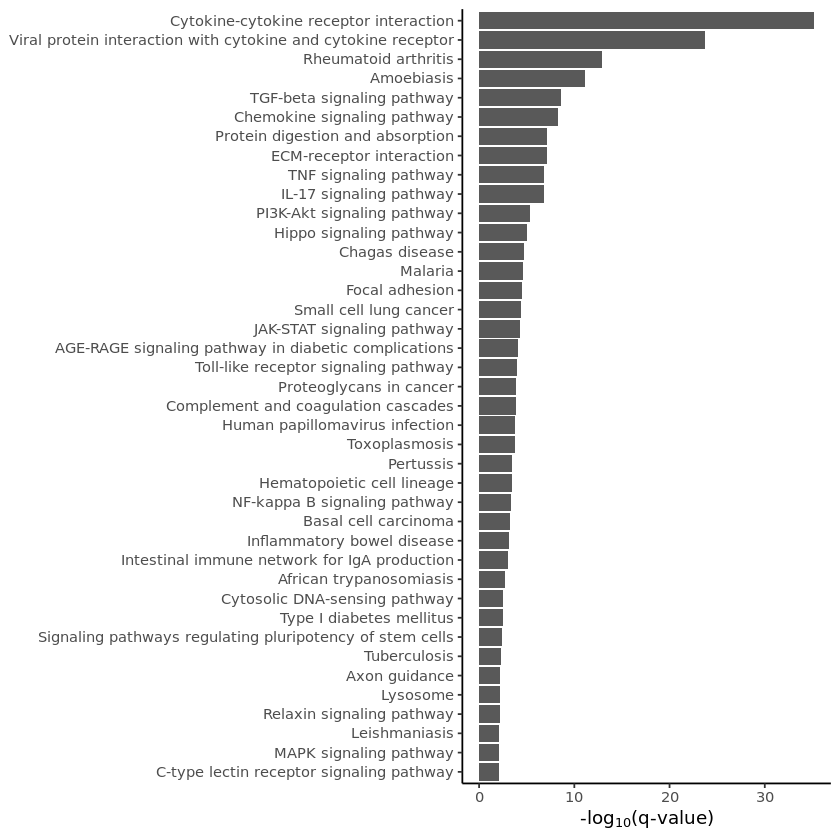

In [12]:
if (nrow(survival_sig_df) > 0) {
    survival_kegg_res <- enrichKEGG(gene = survival_sig_df$entrez_gene_id, organism = "hsa")
    survival_kegg_df <- make_ea_df(survival_kegg_res, ea_type = "KEGG")
    ea_plot(survival_kegg_df %>% dplyr::top_n(n = -40, wt = qval))
}